In [ ]:
# !pip install mediapipe

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## KEYPOINT EXTRACTION

In [2]:
mp

<module 'mediapipe' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\__init__.py'>

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
mp_holistic

<module 'mediapipe.python.solutions.holistic' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\python\\solutions\\holistic.py'>

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  
    results = model.process(image)                
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])


In [9]:
468*3+33*4+21*3+21*3

1662

## DATA ARRANGEMENT

In [10]:
# !pip install moviepy

In [11]:
DATA_PATH = os.path.join('data2') 

# Actions that we try to detect
actions = np.array(['happy','sad','anger','surprise','fear','neutral'])
actions.sort()

# 62 videos
no_sequences = 75

# 30 frames
sequence_length = 30

#start new folder after 30 frames for data prep
start_folder = 30

## Preprocess Data and Create Labels and Features

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [13]:
label_map = {label:num for num, label in enumerate(actions)}

In [14]:
label_map

{'anger': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

In [15]:
DATA_PATH

'data2'

In [16]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
np.array(sequences).shape

(450, 30, 1662)

In [18]:
np.array(labels).shape

(450,)

In [19]:
X = np.array(sequences)

In [20]:
X.shape

(450, 30, 1662)

In [21]:
y = to_categorical(labels).astype(int)

In [22]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [24]:
y_test.shape

(23, 6)

## Build Network

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from keras import backend as K

In [26]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [27]:
import tensorflow as tf

In [28]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomAttention, self).__init__()

    def build(self, input_shape):
        super(CustomAttention, self).build(input_shape)

    def call(self, q, k, v):
        # Calculate attention scores using scalar dot product
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        
        output = tf.matmul(attention_scores, v)
        
        average_attention_score = tf.reduce_mean(attention_scores)
        
        return output, attention_scores, average_attention_score

In [29]:
model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
# LSTM layer
lstm_layer = LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662), return_state=True)
output, state_h, state_c = lstm_layer(X_train) 

attention_layer = CustomAttention()
output, attention_scores, average_attention_score = attention_layer(output, output, output)
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [30]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
average_attention_score

<tf.Tensor: shape=(), dtype=float32, numpy=0.033333335>

In [31]:
def custom_reward(y_true, y_pred, average_attention_score):
    correct_predictions = tf.reduce_sum(y_true * y_pred)
    
    mean_pred_axis_0 = tf.reduce_mean(y_pred, axis=0)
    mean_pred_axis_1 = tf.reduce_mean(y_pred, axis=1, keepdims=True)
    diversity_penalty = tf.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)

    weighted_mistakes_penalty = tf.reduce_sum(tf.square(y_true - y_pred) * tf.constant([1.0, 1.2, 1.5, 1.0, 1.3, 1.5]))
    
    external_metric_bonus = 0.4

    # Include the term for the average attention score
    reward = correct_predictions - 0.1 * diversity_penalty - 0.3 * weighted_mistakes_penalty + 0.4 * external_metric_bonus + 0.2 * average_attention_score

    return reward

In [32]:
def custom_loss_with_reward(y_true, y_pred):
    y_true = K.cast(y_true, dtype=K.dtype(y_pred))
    loss = K.categorical_crossentropy(y_true, y_pred)
    
    # Modify to get the average_attention_score from the attention layer
    _, _, average_attention_score = attention_layer(y_pred, y_pred, y_pred)
    
    reward = custom_reward(y_true, y_pred, average_attention_score)
    
    return loss - 0.1 * reward

In [33]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

In [34]:
model.compile(optimizer=optimizer, loss=custom_loss_with_reward, metrics=['categorical_accuracy'])

In [35]:
X_train.shape,y_train.shape

((427, 30, 1662), (427, 6))

In [36]:
history = model.fit(X_train, y_train, epochs=50, callbacks=[tb_callback])

Epoch 1/50
14/14 [==============================] - 27s 515ms/step - loss: 7.4119 - categorical_accuracy: 0.1920
Epoch 2/50
14/14 [==============================] - 5s 313ms/step - loss: 9.0081 - categorical_accuracy: 0.1967
Epoch 3/50
14/14 [==============================] - 4s 296ms/step - loss: 92.6667 - categorical_accuracy: 0.1733
Epoch 4/50
14/14 [==============================] - 4s 307ms/step - loss: 124.5056 - categorical_accuracy: 0.1616
Epoch 5/50
14/14 [==============================] - 4s 280ms/step - loss: 85.4571 - categorical_accuracy: 0.1616
Epoch 6/50
14/14 [==============================] - 5s 344ms/step - loss: 76.7442 - categorical_accuracy: 0.1780
Epoch 7/50
14/14 [==============================] - 4s 315ms/step - loss: 60.8024 - categorical_accuracy: 0.1874
Epoch 8/50
14/14 [==============================] - 6s 411ms/step - loss: 15.9250 - categorical_accuracy: 0.1639
Epoch 9/50
14/14 [==============================] - 9s 650ms/step - loss: 11.6836 - categorical_

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 128)           916992    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 972838 (3.71 MB)
Trainable params: 972838 (3.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


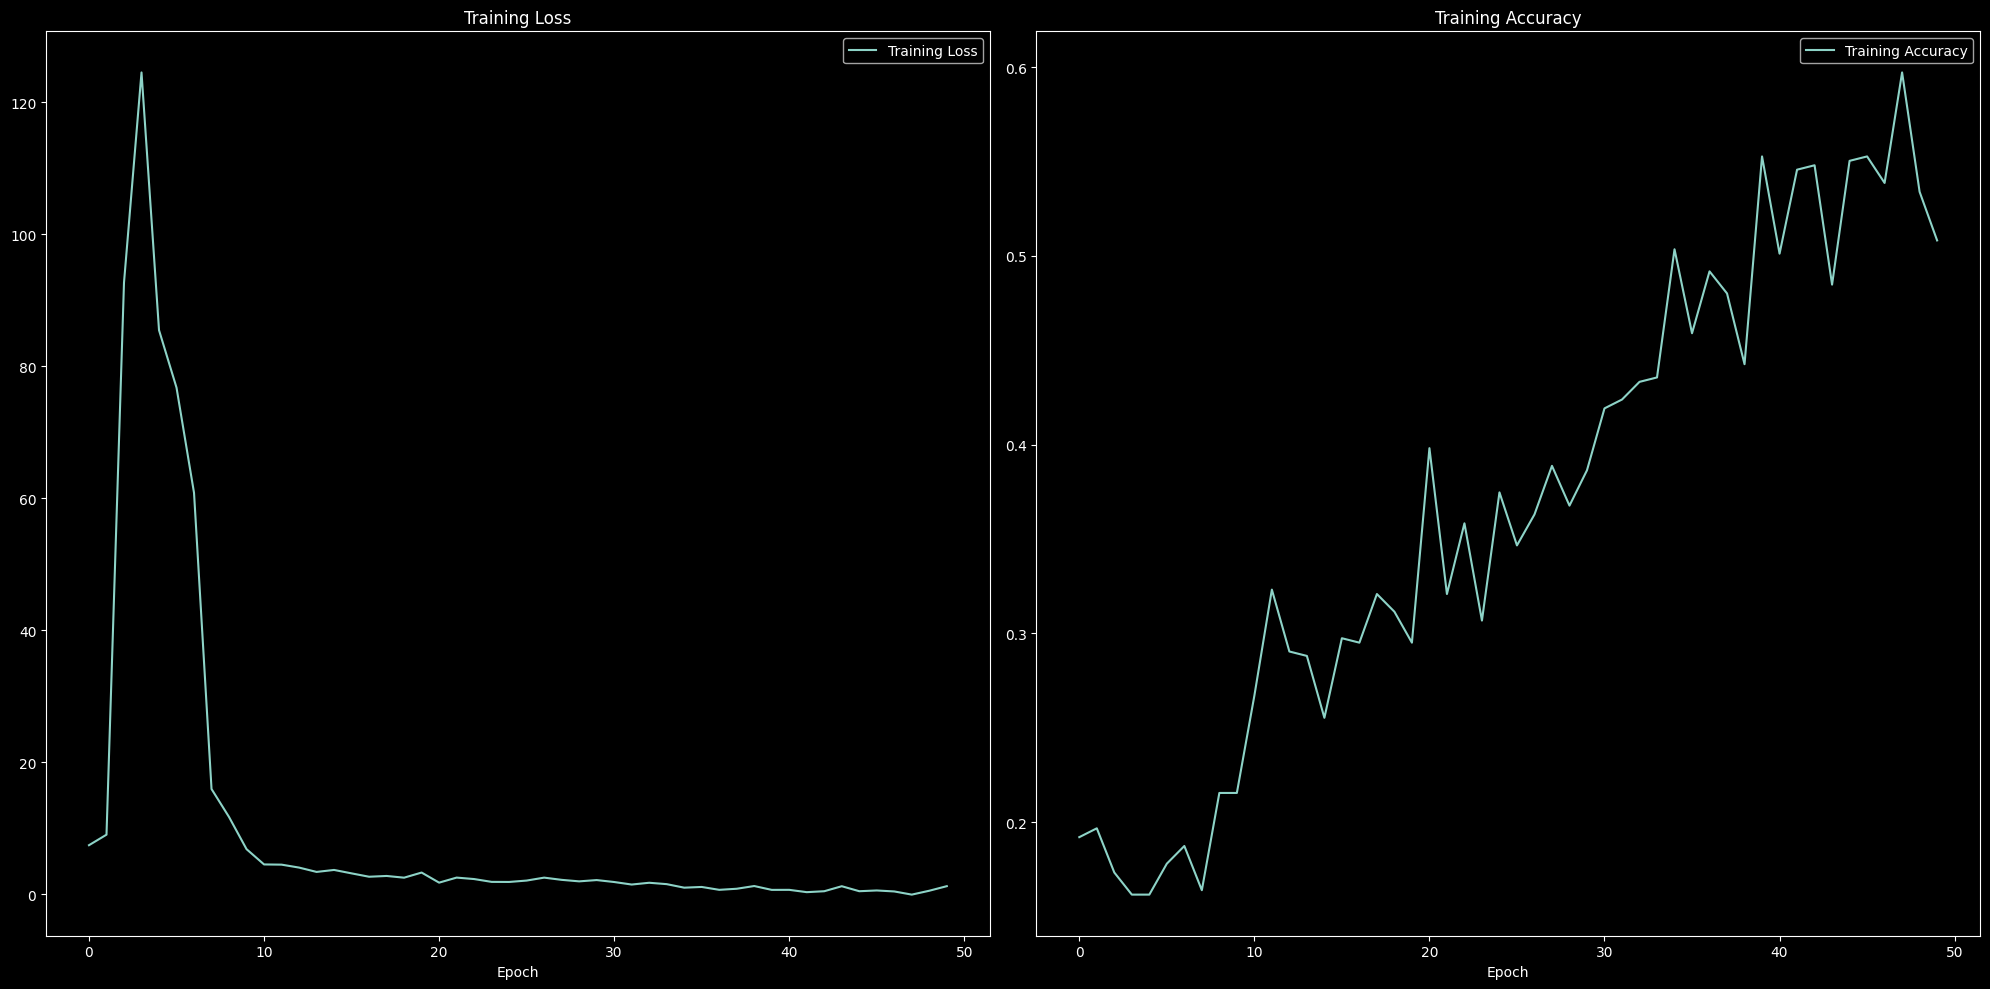

In [38]:
plt.style.use('dark_background')

# Plot loss and accuracy graphs
plt.figure(figsize=(20, 10))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
y_p = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [40]:
y_p.shape

(23, 6)

In [41]:
y_test.shape

(23, 6)

In [42]:
# def calculate_reward(y_true, y_pred):
#     # Correct Predictions
#     correct_predictions = np.sum(y_true * y_pred)

#     # Diversity Penalty
#     mean_pred_axis_0 = np.mean(y_pred, axis=0)
#     mean_pred_axis_1 = np.mean(y_pred, axis=1).reshape(-1, 1)  # Reshape to (19, 1)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)

#     # Weighted Mistakes Penalty
#     weighted_mistakes_penalty = np.sum(np.square(y_true - y_pred) * np.array([1.0, 2.0, 1.5, 1.0, 2.0, 1.5]))

#     # External Metric Bonus
#     external_metric_bonus = 0.2

#     # Final Reward
#     reward = correct_predictions - 0.1 * diversity_penalty - 0.5 * weighted_mistakes_penalty + external_metric_bonus

#     return reward

In [43]:
# calculate_reward(y_test,y_p)

In [44]:
res = model.predict(X_test)

1/1 [==============================] - 0s 169ms/step


In [45]:
X_test

array([[[ 0.52667487,  0.38010314, -1.09710622, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.52668899,  0.37921706, -1.08753181, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.52682149,  0.37816814, -1.06346047, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.53963137,  0.37249374, -1.12892556, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.53965127,  0.37289751, -1.15059769, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54005271,  0.37294075, -1.15990257, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.66993177,  0.52105719, -1.53526425, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.66983807,  0.52218258, -1.49426818, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.66970521,  0.52207559, -1.4654659 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.65232903,  0.52804905, -1.52837861, ...,  

In [46]:
res

array([[3.0910488e-10, 7.3394913e-05, 7.2244316e-06, 9.0475474e-08,
        1.0169535e-06, 9.9991822e-01],
       [1.0314294e-06, 1.5664149e-04, 9.9486154e-01, 8.6884938e-06,
        1.0891584e-04, 4.8631504e-03],
       [1.8382805e-08, 1.2464364e-04, 1.7609745e-01, 7.9536960e-07,
        1.4556338e-05, 8.2376254e-01],
       [6.0940254e-02, 2.3772778e-02, 7.3652428e-01, 4.4232987e-02,
        1.3451251e-01, 1.7259003e-05],
       [6.7948431e-01, 8.6940937e-03, 1.8521211e-03, 1.8539290e-01,
        1.2457664e-01, 2.7112430e-09],
       [3.8671802e-04, 1.8812667e-01, 1.9037705e-05, 2.5523864e-04,
        7.9436958e-01, 1.6842812e-02],
       [3.2235755e-07, 1.2613036e-04, 9.9132758e-01, 3.6165757e-06,
        4.6424317e-05, 8.4958589e-03],
       [1.9357918e-07, 9.3095776e-05, 9.7365934e-01, 2.6484602e-06,
        3.8217069e-05, 2.6206471e-02],
       [1.6707023e-06, 3.7426371e-04, 9.9101567e-01, 1.6251801e-05,
        1.5522854e-04, 8.4368698e-03],
       [1.5871185e-03, 2.6558354e-03,

In [47]:
actions[np.argmax(res[4])]

'anger'

In [48]:
actions[np.argmax(y_test[4])]

'anger'

In [49]:
model.save('action_with_Reward_3.h5')

H:\PYTHON\PYTHON SYSTEM FILES\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [51]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 150ms/step


In [52]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [53]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[19,  0],
        [ 2,  2]],

       [[18,  1],
        [ 3,  1]],

       [[11,  6],
        [ 0,  6]],

       [[19,  1],
        [ 3,  0]],

       [[19,  2],
        [ 2,  0]],

       [[19,  0],
        [ 0,  4]]], dtype=int64)

In [54]:
accuracy_score(ytrue, yhat)

0.5652173913043478

In [55]:
for num, prob in enumerate(res):
    print(num,prob)

0 [3.0910488e-10 7.3394913e-05 7.2244316e-06 9.0475474e-08 1.0169535e-06
 9.9991822e-01]
1 [1.0314294e-06 1.5664149e-04 9.9486154e-01 8.6884938e-06 1.0891584e-04
 4.8631504e-03]
2 [1.8382805e-08 1.2464364e-04 1.7609745e-01 7.9536960e-07 1.4556338e-05
 8.2376254e-01]
3 [6.0940254e-02 2.3772778e-02 7.3652428e-01 4.4232987e-02 1.3451251e-01
 1.7259003e-05]
4 [6.7948431e-01 8.6940937e-03 1.8521211e-03 1.8539290e-01 1.2457664e-01
 2.7112430e-09]
5 [3.8671802e-04 1.8812667e-01 1.9037705e-05 2.5523864e-04 7.9436958e-01
 1.6842812e-02]
6 [3.2235755e-07 1.2613036e-04 9.9132758e-01 3.6165757e-06 4.6424317e-05
 8.4958589e-03]
7 [1.9357918e-07 9.3095776e-05 9.7365934e-01 2.6484602e-06 3.8217069e-05
 2.6206471e-02]
8 [1.6707023e-06 3.7426371e-04 9.9101567e-01 1.6251801e-05 1.5522854e-04
 8.4368698e-03]
9 [1.5871185e-03 2.6558354e-03 9.8655462e-01 2.1030153e-03 7.0621017e-03
 3.7383870e-05]
10 [3.6121815e-05 7.7113986e-01 7.4273528e-05 4.9269589e-04 2.2378895e-01
 4.4680913e-03]
11 [2.8600465e-07 9.

In [56]:
from scipy import stats

In [57]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0), (0, 255, 0), (0, 0, 255)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame


In [58]:
# prob_viz(res[0], actions, image, colors)

In [59]:
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res[2], actions, image, colors))

In [60]:
import tensorflow as tf

In [61]:
model = tf.keras.models.load_model("action_with_Reward_3.h5", custom_objects={'custom_loss_with_reward': custom_loss_with_reward})

In [62]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("happy19.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

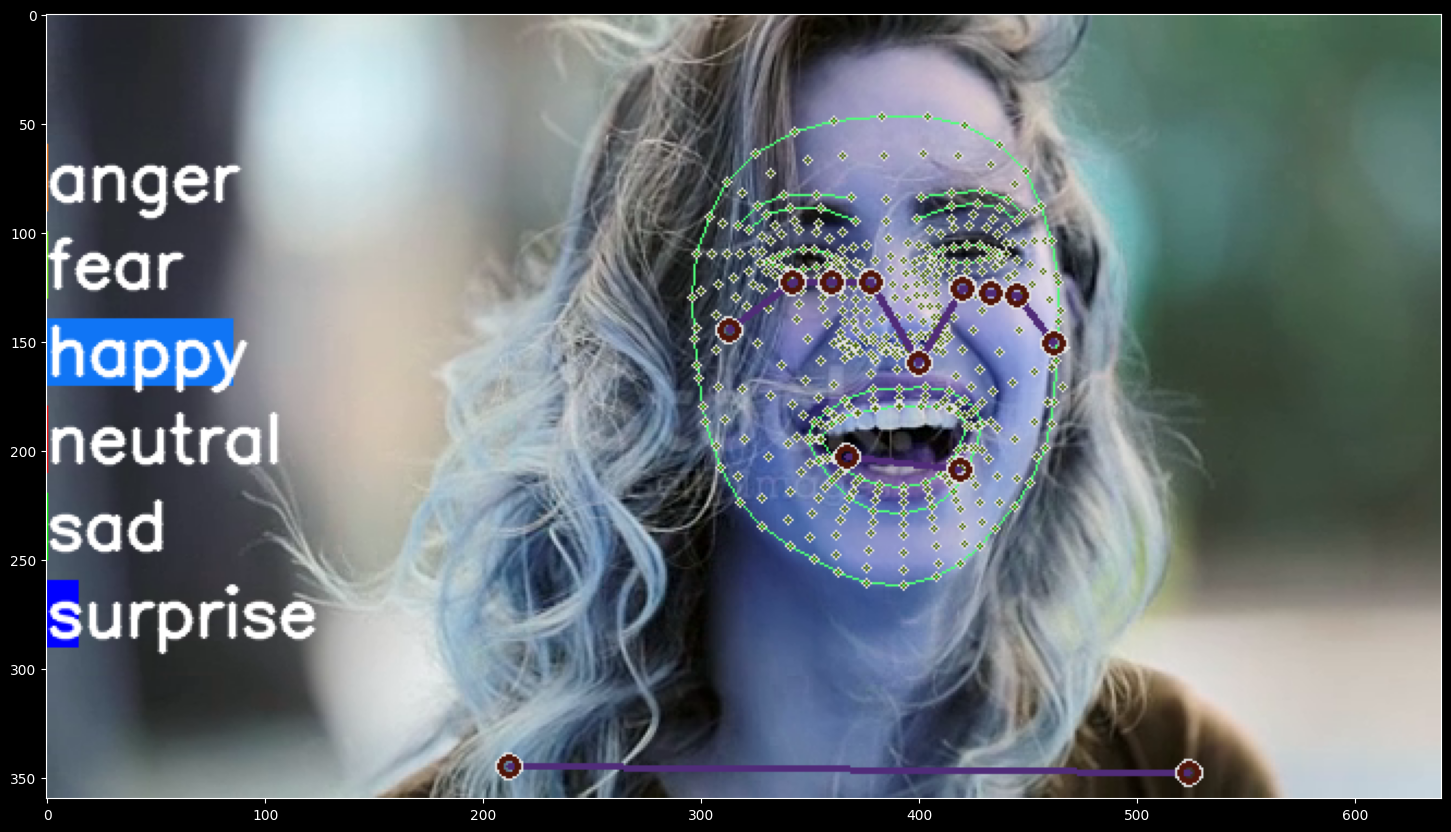

In [63]:
plt.figure(figsize=(18,18))
plt.imshow(image)

In [64]:
# history

In [65]:
res

array([1.6118419e-07, 1.6604394e-04, 8.5159022e-01, 3.3256690e-06,
       4.5923807e-05, 1.4819434e-01], dtype=float32)

In [66]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

anger ----> 1.6118419e-07
fear ----> 0.00016604394
happy ----> 0.8515902
neutral ----> 3.325669e-06
sad ----> 4.5923807e-05
surprise ----> 0.14819434


In [67]:
import numpy as np


# Get the indices of the top 3 elements
top_indices = np.argsort(res)[-2:][::-1]

print("Indices of the top 3 elements:", top_indices)

Indices of the top 3 elements: [2 5]


In [68]:
ans=[]

In [69]:
for i in top_indices:
    ans.append(actions[i])

In [70]:
ans

['happy', 'surprise']

In [71]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("J:/AUTISM DETECTION PROJECT/3DCNN/videos/sad/sad30.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
                       # cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [ ]:
res

In [ ]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(image)

In [72]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

actions=['happy','sad','anger','surprise','fear','neutral']
actions.sort()

cap = cv2.VideoCapture("fear20.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [ ]:
res

In [ ]:
for i in range(len(actions)):
    print(actions[i],"---->",float(res[i]))

In [ ]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 650))
plt.imshow(resized_image)
plt.show()